In [1]:
from prophet import Prophet

In [4]:
import sys
sys.path.insert(0, '/home/tegbe/2023/ccl/timeRobert/')  # Replace 'path/to/parent_directory' with the absolute path to the parent directory

from eda import exp

In [13]:
df = exp.import_data()
df_pdoil = df[['DATE', 'PD_Oil Rate (stb/day)']]
df_pdoil.head(5)

,DATE,PD_Oil Rate (stb/day)
0,1977-04-01,474.600000
1,1977-05-01,524.761905
2,1977-06-01,1096.793103
3,1977-07-01,2372.233010
4,1977-08-01,3357.987013


In [14]:
# Rename columns to meet prophet model template
df_pdoil = df_pdoil.rename(columns={'DATE': 'ds', 'PD_Oil Rate (stb/day)': "y"})
df_pdoil.head(5)

,ds,y
0,1977-04-01,474.600000
1,1977-05-01,524.761905
2,1977-06-01,1096.793103
3,1977-07-01,2372.233010
4,1977-08-01,3357.987013


In [16]:
# Split data frame to train and test
X_train, y_train, X_test, y_test = exp.train_test_split_by_date(df_pdoil, 'ds', 'y', '1996-01-01')

In [21]:
df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

## Fit and train model

#### parameter search

In [52]:
from itertools import product
import numpy as np

# Define hyperparameters to search through
seasonality_modes = ['additive', 'multiplicative']
seasonality_prior_scales = [5.0, 10.0, 15.0]
changepoint_prior_scales = [0.01, 0.05, 0.1]
holidays_prior_scales = [10.0, 15.0, 20.0]
changepoint_ranges = [0.8, 0.9]

# Create a list of all parameter combinations
parameter_grid = list(product(seasonality_modes, seasonality_prior_scales, changepoint_prior_scales, holidays_prior_scales, changepoint_ranges))

# ... (rest of your code remains the same)

# Initialize variables to track best parameters and performance
best_params = None
best_mae = float('inf')  # Set initial value to a very high number

# Loop through each parameter combination
for params in parameter_grid:
    seasonality_mode, seasonality_prior_scale, changepoint_prior_scale, holidays_prior_scale, changepoint_range = params

    # Initialize Prophet model with current parameters
    model = Prophet(
        seasonality_mode=seasonality_mode,
        seasonality_prior_scale=seasonality_prior_scale,
        changepoint_prior_scale=changepoint_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        changepoint_range=changepoint_range
    )

    # Fit the model on training data
    model.fit(df_train)

    # Make predictions on validation data
    future = model.make_future_dataframe(periods=len(df_test))
    forecast = model.predict(future)

    forecast_subset = forecast.iloc[-len(df_test):]

    # Calculate Mean Absolute Error (MAE)
    mae = np.mean(np.abs(df_test['y'].values - forecast_subset['yhat'].values))

    # Track parameters with the best performance
    if mae < best_mae:
        best_mae = mae
        best_params = {
            'seasonality_mode': seasonality_mode,
            'seasonality_prior_scale': seasonality_prior_scale,
            'changepoint_prior_scale': changepoint_prior_scale,
            'holidays_prior_scale': holidays_prior_scale,
            'changepoint_range': changepoint_range
        }

# Output the best parameters found
print("Best parameters:", best_params)


11:04:29 - cmdstanpy - INFO - Chain [1] start processing
11:04:29 - cmdstanpy - INFO - Chain [1] done processing


11:04:29 - cmdstanpy - INFO - Chain [1] start processing
11:04:29 - cmdstanpy - INFO - Chain [1] done processing
11:04:29 - cmdstanpy - INFO - Chain [1] start processing
11:04:29 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1] done processing
11:04:30 - cmdstanpy - INFO - Chain [1] start processing
11:04:30 - cmdstanpy - INFO - Chain [1]

Best parameters: None


In [63]:
model = Prophet(
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10.0,
    changepoint_prior_scale=0.1,#0.05
    holidays_prior_scale=15.0,
    changepoint_range=0.8
)
model.fit(df_train)

11:09:50 - cmdstanpy - INFO - Chain [1] start processing
11:09:50 - cmdstanpy - INFO - Chain [1] done processing


In [64]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
571,1996-11-26,1809.805555,1032.447528,2656.211824
572,1996-11-27,1831.807120,957.911580,2667.985188
573,1996-11-28,1851.467199,990.257382,2699.248381
574,1996-11-29,1868.409012,1092.856136,2668.394994
575,1996-11-30,1882.351146,988.971293,2696.130811


/home/tegbe/2023/ccl/timeRobert/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/tegbe/2023/ccl/timeRobert/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


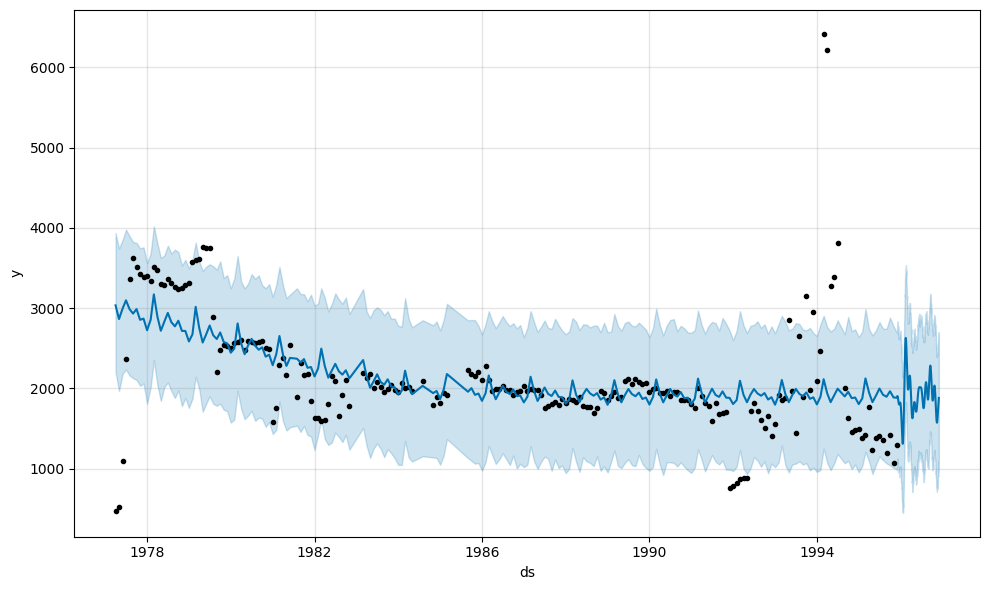

In [65]:
fig1 = model.plot(forecast)

In [66]:
forecast['ds']

0     1977-04-01
1     1977-05-01
2     1977-06-01
3     1977-07-01
4     1977-08-01
         ...    
571   1996-11-26
572   1996-11-27
573   1996-11-28
574   1996-11-29
575   1996-11-30
Name: ds, Length: 576, dtype: datetime64[ns]

In [67]:
X_train.shape, y_train.shape, forecast[['ds']].shape, forecast[['yhat']].shape

((211, 1), (211,), (576, 1), (576, 1))

In [68]:
y_train

0       474.600000
1       524.761905
2      1096.793103
3      2372.233010
4      3357.987013
          ...     
206    1359.500000
207    1201.900000
208    1417.258065
209    1073.344482
210    1292.709677
Name: y, Length: 211, dtype: float64

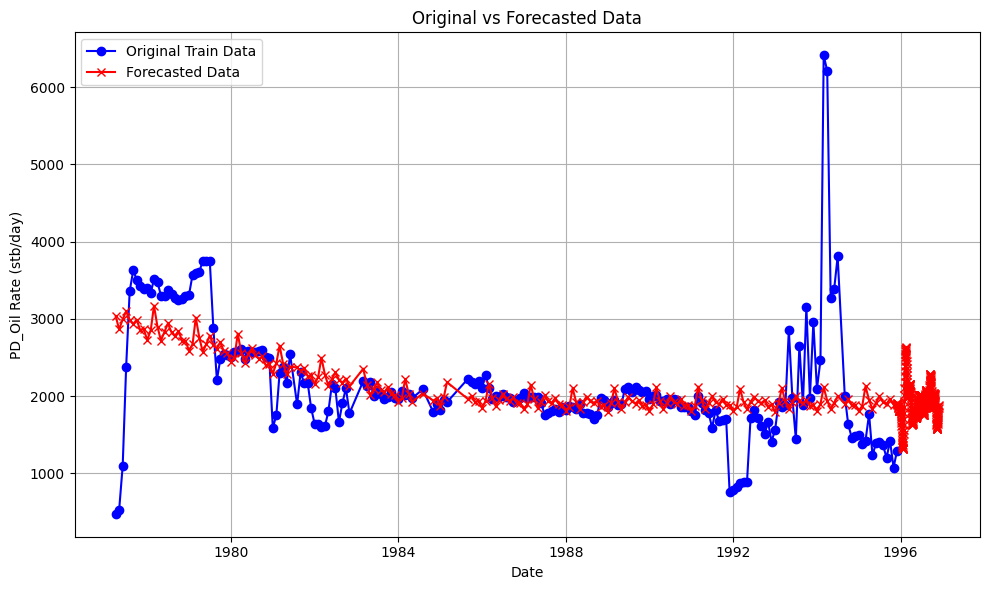

In [69]:
import matplotlib.pyplot as plt

def plot_train_infer(X_train, y_train, forecast_ds):
    plt.figure(figsize=(10, 6))

    # Plot original training data
    plt.plot(X_train['ds'], y_train, color='blue', label='Original Train Data', marker='o')

    # Plot forecasted data
    plt.plot(forecast_ds['ds'], forecast_ds['yhat'], color='red', label='Forecasted Data', marker='x')

    plt.title('Original vs Forecasted Data')
    plt.xlabel('Date')
    plt.ylabel('PD_Oil Rate (stb/day)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_train_infer(X_train, y_train, forecast)